In [1]:
import pandas as pd
import numpy as np
import datetime as datetime

import seaborn as sns
from matplotlib import pyplot as plt

import joblib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters

from matplotlib.ticker import PercentFormatter

import write_data_table

In [2]:
taiwan_excel = "../../data/raw/FAB Data for Stemly_20220906.xlsx"

In [3]:
inv_df = pd.read_excel(taiwan_excel, sheet_name='P&G Inventory (month-end)')
shipment_df = pd.read_excel(taiwan_excel, sheet_name='Shipment')
shortname_df = pd.read_excel(taiwan_excel, sheet_name='shortname')
offtake_df = pd.read_excel(taiwan_excel, sheet_name='Offtake')
trd_inv_df = pd.read_excel(taiwan_excel, sheet_name='Trade Inventory')
price_df = pd.read_excel(taiwan_excel, sheet_name='Pricing',skiprows = [0])

In [4]:
fab_fcst_excel_name = "../../data/raw/TW FAB DP monthly fcst.xlsx"
fab_fcst_jun_ver = pd.read_excel(fab_fcst_excel_name, sheet_name='Jun Fcst')
fab_fcst_jul_ver = pd.read_excel(fab_fcst_excel_name, sheet_name='Jul Fcst')
fab_fcst_aug_ver = pd.read_excel(fab_fcst_excel_name, sheet_name='Aug Fcst')

In [5]:
fab_fcst_jun_ver1 = fab_fcst_jun_ver.melt(id_vars=[ 'sku'],var_name="date",value_name="fab_forecast")
fab_fcst_jun_ver1['version'] = "June"
fab_fcst_jul_ver1 = fab_fcst_jul_ver.melt(id_vars=[ 'sku'],var_name="date",value_name="fab_forecast")
fab_fcst_jul_ver1['version'] = "July"
fab_fcst_aug_ver1 = fab_fcst_aug_ver.melt(id_vars=[ 'sku'],var_name="date",value_name="fab_forecast")
fab_fcst_aug_ver1['version'] = "August"

In [6]:
fab_fcst_all = pd.concat([fab_fcst_jun_ver1,fab_fcst_jul_ver1,fab_fcst_aug_ver1]).reset_index(drop=True)
fab_fcst_all.head()

,sku,date,fab_forecast,version
0,82332800,2022-05-01,82.636667,June
1,80702886,2022-05-01,141.895522,June
2,82332208,2022-05-01,145.169082,June
3,82332932,2022-05-01,6026.432514,June
4,80710476,2022-05-01,594.000000,June


In [7]:
price_df.drop(columns={'Unnamed: 0'},inplace=True)
price_df.columns = ['sku_comp','po_code','sku','sku_name','sku_chinese_desc','list_price','suggested_regular_price']
sku_code_conv = price_df[['sku_comp','sku']].drop_duplicates()
price_df['sku'] = price_df['sku'].astype('int64').astype(str)

In [8]:
inv_df.rename(columns = {'Brand_':'Brand', 'Descr':'Description', 'Casecnt':'Pieces_Per_Case', 'Qty(IT)' : 'Quantity', },inplace=True)
inv_df.columns = inv_df.columns.str.replace(' ','_')
inv_df.columns = inv_df.columns.str.lower()

inv_df['manf_date'] = pd.to_datetime(inv_df['manf_date'])
inv_df['expiry'] = pd.to_datetime(inv_df['expiry'])
inv_df['dc_stop_ship_date'] = pd.to_datetime(inv_df['dc_stop_ship_date'])
inv_df['transaction_date'] = pd.to_datetime(inv_df['transaction_date'])
inv_df['month_date'] = inv_df['date'].apply(lambda _: datetime.datetime.strftime(_,'%Y-%m-01'))
inv_df['month_date'] = pd.to_datetime(inv_df['month_date'])
inv_df.rename(columns={'sku':'sku_base'},inplace=True)

inv_df = pd.merge(inv_df,sku_code_conv,left_on='sku_base',right_on='sku_comp',how='left')
inv_df.loc[inv_df['sku'].isnull(),'sku'] = inv_df.loc[inv_df['sku'].isnull(),'sku_base'] 
inv_df['sku'] = inv_df['sku'].astype('int64').astype(str)


In [9]:
shipment_df.columns = ['date','sku','sku_desc','shipment_volume','shipment_value']
shipment_df['month_date'] = shipment_df['date'].apply(lambda _: datetime.datetime.strftime(_,'%Y-%m-01'))
shipment_df1 = shipment_df.copy()
shipment_df.loc[shipment_df['sku'] == 82332210,'sku'] = 80702886
shipment_df['month_date'] = pd.to_datetime(shipment_df['month_date'])
shipment_df1['sku'] = shipment_df1['sku'].astype('int64').astype(str)
shipment_df['sku'] = shipment_df['sku'].astype('int64').astype(str)

In [10]:
offtake_df.columns = ['prod_hierarchy','sku_desc_twn','year','month','day','offtake','sku']
offtake_df['month'] = offtake_df['month'].apply(lambda _: datetime.datetime.strptime(_,"%b")).dt.month
offtake_df['date'] = pd.to_datetime( offtake_df[['year', 'month', 'day']])
offtake_df['month_date'] = offtake_df['date'].apply(lambda _: datetime.datetime.strftime(_,'%Y-%m-01'))
offtake_df['month_date'] = pd.to_datetime(offtake_df['month_date'])
offtake_df['sku'] = offtake_df['sku'].astype('int64').astype(str)

In [11]:
trd_inv_df.columns = ['date','prod_code','sku','prod_name','inv_value','price','inv_qty']
trd_inv_df['month_date'] = trd_inv_df['date'].apply(lambda _: datetime.datetime.strftime(_,'%Y-%m-01'))
trd_inv_df['month_date'] = pd.to_datetime(trd_inv_df['month_date'])
trd_inv_df['sku'] = trd_inv_df['sku'].astype('int64').astype(str)

inv_df['facility'] = inv_df['facility'].astype(str)

In [12]:
offtake_df1 = offtake_df[['prod_hierarchy','offtake','sku','month_date']]
offtake_month2 = offtake_df1.set_index("month_date").groupby(["prod_hierarchy","sku"]).resample("MS").sum().reset_index()
offtake_month2.head()

,prod_hierarchy,sku,month_date,offtake
0,FAB,80692947,2021-10-01,619
1,FAB,80692947,2021-11-01,2172
2,FAB,80692947,2021-12-01,353
3,FAB,80692947,2022-01-01,643
4,FAB,80692947,2022-02-01,572


In [13]:
att_off_df = offtake_df[['prod_hierarchy','sku','sku_desc_twn']].drop_duplicates()
att_off_df = att_off_df.groupby('sku').first().reset_index()
att_trd_df = trd_inv_df[['prod_code','sku','prod_name']].drop_duplicates()
att_trd_df = att_trd_df.groupby('sku').first().reset_index()
att_ship_df = shipment_df1[['sku_desc','sku']].drop_duplicates()
att_ship_df = att_ship_df[att_ship_df['sku'] != '82332210']
att_inv_df = inv_df[['description','sku']].drop_duplicates()
att_inv_df = att_inv_df.groupby('sku').first().reset_index()

In [14]:
att_df  = pd.merge(att_ship_df,att_off_df,on=['sku'],how='left')
att_df  = pd.merge(att_df,att_trd_df,on=['sku'],how='left')
att_df  = pd.merge(att_df,att_inv_df,on=['sku'],how='left')

In [15]:
offtake_df_weekly = offtake_df[['offtake','sku','date']].set_index("date").groupby(["sku"]).resample("W-Mon").sum().reset_index()
offtake_df_weekly = pd.merge(offtake_df_weekly,price_df[['sku','list_price','suggested_regular_price']])


In [16]:
offtake_df_copy = offtake_df.copy()
offtake_df = offtake_df[['sku','date','offtake']]

In [17]:
actuals_sellin = shipment_df.set_index("date").groupby('sku').resample('MS',label='left',closed = 'left').agg({'shipment_volume':'sum'}).reset_index()
actuals_sellin['sku'] = actuals_sellin['sku'].astype('int64')
actuals_sellin.head()

,sku,date,shipment_volume
0,80692947,2021-10-01,4000
1,80692947,2021-11-01,0
2,80692947,2021-12-01,0
3,80692947,2022-01-01,0
4,80692947,2022-02-01,1001


In [18]:
offtake_df_monthly = offtake_df.set_index("date").groupby('sku').resample('MS',label='left',closed = 'left').agg({'offtake':'sum'}).reset_index()
offtake_df_monthly['sku'] = offtake_df_monthly['sku'].astype('int64')

In [19]:
predict_df_monthly = pd.read_csv("../../data/raw/predict_df_monthly.csv")
predict_df_monthly.drop(columns={'Unnamed: 0'},errors='ignore',inplace=True)
predict_df_monthly.rename(columns={'ts':'date','yhat':'offtake_forecast'},inplace=True)
predict_df_monthly.head()

,sku,date,offtake_forecast
0,80692947,2021-10-01,469.0
1,80692947,2021-11-01,2089.0
2,80692947,2021-12-01,353.0
3,80692947,2022-01-01,706.0
4,80692947,2022-02-01,508.0


In [20]:
taiwan_sellin = pd.read_excel("../../data/raw/Taiwan_sell_in.xlsx", sheet_name='Sheet1')
taiwan_sellin.drop(columns={'Unnamed: 0'},errors='ignore',inplace=True)
taiwan_sellin.rename(columns={'ts':'date','Shipment':'sellin_forecast'},inplace=True)
taiwan_sellin = taiwan_sellin[['date','sku','sellin_forecast']]
taiwan_sellin

,date,sku,sellin_forecast
0,2021-08-23,80702886,0
1,2021-08-30,80702886,0
2,2021-09-06,80702886,0
3,2021-09-13,80702886,0
4,2021-09-20,80702886,0
...,...,...,...
718,2023-05-08,82332932,500
719,2023-05-15,82332932,0
720,2023-05-22,82332932,0
721,2023-05-29,82332932,0


In [21]:
act_vs_sellin_fab = pd.merge(fab_fcst_all,actuals_sellin,on=['sku','date'],how='left')
act_vs_sellin_fab['fab_forecast'] = act_vs_sellin_fab['fab_forecast'].astype('int64')
act_vs_sellin_fab['sp1_fab'] = act_vs_sellin_fab['shipment_volume']/act_vs_sellin_fab['fab_forecast']
act_vs_sellin_fab = act_vs_sellin_fab[act_vs_sellin_fab['date'].isin(['2022-05-01','2022-06-01','2022-07-01','2022-08-01'])]
act_vs_sellin_fab = pd.merge(act_vs_sellin_fab,offtake_df_monthly,on=['sku','date'],how='left')
predict_df_monthly['sku'] = predict_df_monthly['sku'].astype('int64')
predict_df_monthly['date'] = pd.to_datetime(predict_df_monthly['date'])
act_vs_sellin_fab = pd.merge(act_vs_sellin_fab,predict_df_monthly,on=['sku','date'],how='left')
act_vs_sellin_fab = pd.merge(act_vs_sellin_fab,taiwan_sellin,on=['sku','date'],how='left')
act_vs_sellin_fab.fillna(0,inplace=True)
act_vs_sellin_fab.head()

,sku,date,fab_forecast,version,shipment_volume,sp1_fab,offtake,offtake_forecast,sellin_forecast
0,82332800,2022-05-01,82,June,0.0,0.000000,56.0,65.0,0.0
1,80702886,2022-05-01,141,June,272.0,1.929078,71.0,65.0,0.0
2,82332208,2022-05-01,145,June,1600.0,11.034483,550.0,459.0,0.0
3,82332932,2022-05-01,6026,June,6300.0,1.045470,2148.0,2066.0,0.0
4,80710476,2022-05-01,594,June,1100.0,1.851852,78.0,85.0,0.0


In [22]:
all_fcst_compare = act_vs_sellin_fab.copy()
all_fcst_compare.drop(columns={'sp1_fab'},inplace=True)
all_fcst_compare.rename(columns={'offtake':'offtake_actuals'},inplace=True)
all_fcst_compare = all_fcst_compare.melt(id_vars=[ 'sku','date','version'],var_name="type",value_name="value")
all_fcst_compare

,sku,date,version,type,value
0,82332800,2022-05-01,June,fab_forecast,82.0
1,80702886,2022-05-01,June,fab_forecast,141.0
2,82332208,2022-05-01,June,fab_forecast,145.0
3,82332932,2022-05-01,June,fab_forecast,6026.0
4,80710476,2022-05-01,June,fab_forecast,594.0
...,...,...,...,...,...
350,80710476,2022-08-01,August,sellin_forecast,720.0
351,82332207,2022-08-01,August,sellin_forecast,0.0
352,82332219,2022-08-01,August,sellin_forecast,0.0
353,80692947,2022-08-01,August,sellin_forecast,2247.0


In [23]:
all_fcst_compare.type.unique()

array(['fab_forecast', 'shipment_volume', 'offtake_actuals',
       'offtake_forecast', 'sellin_forecast'], dtype=object)

In [24]:
write_data_table.send_data(all_fcst_compare,"fcst_vs_Actuals_taiwan","w6")

Index(['sku', 'date', 'version', 'type', 'value'], dtype='object')


In [25]:
act_vs_fcst_comp = act_vs_sellin_fab.copy()
act_vs_fcst_comp['acc_sell_in_stm_shipment'] = 1- (np.abs(act_vs_fcst_comp["shipment_volume"] - act_vs_fcst_comp["sellin_forecast"])/ act_vs_fcst_comp["shipment_volume"] )
act_vs_fcst_comp['acc_sell_in_fab_shipment'] = 1- (np.abs(act_vs_fcst_comp["shipment_volume"] - act_vs_fcst_comp["fab_forecast"])/ act_vs_fcst_comp["shipment_volume"] )
act_vs_fcst_comp['acc_sell_in_stm_offtake'] = 1- (np.abs(act_vs_fcst_comp["offtake"] - act_vs_fcst_comp["sellin_forecast"])/ act_vs_fcst_comp["offtake"] )
act_vs_fcst_comp['acc_sell_in_fab_offtake'] = 1- (np.abs(act_vs_fcst_comp["offtake"] - act_vs_fcst_comp["fab_forecast"])/ act_vs_fcst_comp["offtake"] )
act_vs_fcst_comp

,sku,date,fab_forecast,version,shipment_volume,sp1_fab,offtake,offtake_forecast,sellin_forecast,acc_sell_in_stm_shipment,acc_sell_in_fab_shipment,acc_sell_in_stm_offtake,acc_sell_in_fab_offtake
0,82332800,2022-05-01,82,June,0.0,0.000000,56.0,65.0,0.0,NaN,-inf,0.000000,0.535714
1,80702886,2022-05-01,141,June,272.0,1.929078,71.0,65.0,0.0,0.0,0.518382,0.000000,0.014085
2,82332208,2022-05-01,145,June,1600.0,11.034483,550.0,459.0,0.0,0.0,0.090625,0.000000,0.263636
3,82332932,2022-05-01,6026,June,6300.0,1.045470,2148.0,2066.0,0.0,0.0,0.956508,0.000000,-0.805400
4,80710476,2022-05-01,594,June,1100.0,1.851852,78.0,85.0,0.0,0.0,0.540000,0.000000,-5.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,80710476,2022-08-01,82,August,720.0,8.780488,396.0,73.0,720.0,1.0,0.113889,0.181818,0.207071
67,82332207,2022-08-01,75,August,0.0,0.000000,78.0,25.0,0.0,NaN,-inf,0.000000,0.961538
68,82332219,2022-08-01,147,August,0.0,0.000000,333.0,43.0,0.0,NaN,-inf,0.000000,0.441441
69,80692947,2022-08-01,262,August,2247.0,8.576336,1346.0,267.0,2247.0,1.0,0.116600,0.330609,0.194651


In [26]:
act_vs_sellin_fab.to_csv("act_vs_sellin_fab.csv")

In [27]:
offtake_df = offtake_df.drop_duplicates()
offtake_df[ (offtake_df['sku'] == '82332932') & (offtake_df['date'] >= '2022-06-06') & (offtake_df['date'] <= '2022-07-03')]

,sku,date,offtake
273,82332932,2022-06-06,21
274,82332932,2022-06-07,14
275,82332932,2022-06-08,27
276,82332932,2022-06-09,24
277,82332932,2022-06-10,32
278,82332932,2022-06-11,20
279,82332932,2022-06-12,20
280,82332932,2022-06-13,31
281,82332932,2022-06-14,611
282,82332932,2022-06-15,48


In [28]:
main_index = ['sku']
freq= 'W-Mon'
unique_id = offtake_df[main_index].drop_duplicates().reset_index(drop=True)
unique_id['id'] = unique_id.index
print(offtake_df.shape)
req_data = pd.merge(offtake_df,unique_id,on=main_index)
print(req_data.shape)
min_date = req_data.date.min()
max_date = req_data.date.max()
all_ids = req_data.id.unique()
all_ids_df = pd.DataFrame( all_ids)
all_ids_df.columns = ['id']
all_ids_df.head()
all_ids_df['join_val'] = 1

all_dates = pd.date_range(
    start=str(min_date.date()),
    end=str(max_date.date()),
    freq=freq,
)
all_dates_df = pd.DataFrame(all_dates)
all_dates_df.columns=['date']
all_dates_df['join_val'] = 1
all_dates_df = pd.merge(all_dates_df,all_ids_df,on=['join_val'],how='outer')
data = req_data.set_index("date").groupby('id').resample(freq,label='left',closed = 'left').agg({'offtake':'sum'}).reset_index()
data2 = data.copy()
print(data.shape)
min_date_id = data.groupby('id')['date'].min().reset_index()
min_date_id.rename(columns={'date':'min_date'},inplace=True)
data = pd.merge(all_dates_df,data,on=['date','id'],how='left')
print(data.shape)

data = pd.merge(data,min_date_id,on=['id'],how='left')

data = data[data['date'] >= data['min_date']]
data = data.fillna(0)
data = pd.merge(data,unique_id,on=['id'])

data.drop(columns={'min_date','join_val','id'},inplace=True)
print(data.shape)
data = pd.merge(data,price_df[['sku','list_price','suggested_regular_price']],on='sku')
data['sku']= data['sku'].astype('int64')
offtake_final = data.copy()

(2273, 3)
(2273, 4)
(393, 3)
(432, 4)
(387, 3)


In [29]:
freq = 'W-Mon'
shipment_df_final = shipment_df[['date','sku','shipment_volume','shipment_value']]
shipment_df_final['sku']= shipment_df_final['sku'].astype('int64')
#shipment_df_final = shipment_df_final.set_index("date").groupby(['sku']).resample(freq,label='left',closed = 'left').agg({'shipment_volume':'sum','shipment_value':'sum'}).reset_index()
shipment_df_final.head()

,date,sku,shipment_volume,shipment_value
0,2022-07-15,80692947,2260,2079200.0
1,2022-07-14,82332932,2500,1150000.0
2,2022-07-06,82332932,2000,920000.0
3,2022-05-23,82332207,-1,-1100.0
4,2022-05-19,80702886,0,-261.0


In [30]:
freq = 'MS'
inv_df_final = inv_df[inv_df['sku_base'].isin(offtake_final.sku.unique())]
inv_df_final = inv_df_final[['date','sku','quantity']]
inv_df_final = inv_df_final.set_index("date").groupby(['sku']).resample(freq,label='left',closed = 'left').agg({'quantity':'sum'}).reset_index()
inv_df_final.rename(columns={'quantity':'inventory'},inplace=True)
inv_df_final.head()

,sku,date,inventory
0,80692947,2021-10-01,1992
1,80692947,2021-11-01,1991
2,80692947,2021-12-01,1991
3,80692947,2022-01-01,1991
4,80692947,2022-02-01,990


In [31]:
att_df = att_df[['sku_desc', 'sku', 'prod_hierarchy', 'prod_code', 'description']]
att_df

,sku_desc,sku,prod_hierarchy,prod_code,description
0,FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...,80692947,FAB,10024911.0,FAB ULTRAR CRM 56.7G(2.0OZ)X6X13 TW
1,FAB ULTRAR CRM 56.7G(2.0OZ)X6X15 TW [IT] [8233...,82332932,FAB,9864145.0,FAB ULTRAR CRM 56.7G(2.0OZ)X6X13 TW
2,FAB ULTRA HYDRATE SERUM 50MLX3X23 TW [IT] [823...,82332207,FAB,10024914.0,FAB ULTRAT SERUM P 50ML(1.7OZ)X3X23
3,FAB ULTRA OAT SOOTHING TNR 177MLX6X8 TW [IT] [...,82332219,FAB,10024913.0,FAB ULTRAR TONER P 177ML(60Z)X6X8 NONSTK
4,FAB PURE SKIN FACE CLEANSER 142GX57 TW [IT] [8...,80702886,FAB,10024916.0,FAB CLEANSER EUP 142G(50Z)X57 NONSTK
5,FAB ULTRA REPAIR OAT MASK 56.7GX42 [IT] [82332...,82332208,FAB,9222618.0,FAB ULTRAR MASK 56.7G(2.0OZ)X42 NONSTK
6,FAB ULTRAR OILC MOIST 50ML 1.7OZX6X8 TW [IT] [...,80710476,FAB,9222614.0,FAB ULT OILC MOIST 50ML(1.7OZ)X6X8
7,FAB FACIAL RAD PAD 60CTX3X12 TW [IT] [82332800...,82332800,FAB,10080881.0,FAB ULTRAR TONER P 177ML(6OZ)X6X8 NONSTK
8,FAB (ULTRA CRM 56.7GX4)X1 TW [CS] [80728046] (...,80728046,NaN,NaN,FAB SOS燕麥保濕霜禮盒


## ABC -XYZ

In [32]:
index_var = 'sku'
date_var = 'date'
sales_var = 'offtake'
price_var = 'list_price'


abc_data = offtake_df_weekly[[index_var, date_var, sales_var,price_var]]
xyz_data = offtake_df_weekly[[index_var, date_var, sales_var,price_var]]

abc_data['revenue'] = abc_data[sales_var]*abc_data[price_var]
abc_data = abc_data.groupby([index_var], as_index = False).revenue.sum()

abc_data = abc_data.sort_values('revenue', ascending=False)
abc_data['rev_cumsum'] = abc_data['revenue'].cumsum()/abc_data['revenue'].sum()

abc_data['ABC'] = 'C'
abc_data.loc[abc_data['rev_cumsum']<=0.9, 'ABC'] = 'B'
abc_data.loc[abc_data['rev_cumsum']<=0.8, 'ABC'] = 'A'


xyz_data['week'] = xyz_data[date_var].dt.week
xyz_data = xyz_data.groupby([index_var, date_var], as_index  = False)[sales_var].sum()

xyz_data_calc=xyz_data.groupby(index_var,as_index=False)[sales_var].agg(['std','mean']).reset_index()
xyz_data_calc['CV'] = xyz_data_calc['std']/xyz_data_calc['mean']
xyz_data_calc.loc[xyz_data_calc['CV']<=1,'XYZ'] = 'Y'
xyz_data_calc.loc[xyz_data_calc['CV']<=0.5,'XYZ'] = 'X'
xyz_data_calc.loc[xyz_data_calc['CV']>1,'XYZ'] = 'Z'
abc_xyz= abc_data.merge(xyz_data_calc, how= 'left', on = [index_var])
abc_xyz['ABC_XYZ'] = abc_xyz['ABC']+abc_xyz['XYZ']
abc_xyz['revenue'] = abc_xyz['revenue'].round(2)
abc_xyz['rev_cumsum'] = abc_xyz['rev_cumsum'].round(2)
abc_xyz['std'] = abc_xyz['std'].round(2)
abc_xyz['mean'] = abc_xyz['mean'].round(2)
abc_xyz['CV'] = abc_xyz['CV'].round(2)
abc_xyz.head()

,sku,revenue,rev_cumsum,ABC,std,mean,CV,XYZ,ABC_XYZ
0,82332932,9132840.0,0.40,A,455.00,360.98,1.26,Z,AZ
1,80692947,8050000.0,0.76,A,261.85,190.22,1.38,Z,AZ
2,82332208,1370735.2,0.82,B,52.29,37.38,1.40,Z,BZ
3,82332219,1343229.3,0.88,B,37.11,38.56,0.96,Y,BY
4,80710476,865440.0,0.92,C,62.24,70.71,0.88,Y,CY


In [33]:
ship_month = shipment_df.set_index("month_date").groupby(["sku", "sku_desc"]).resample("MS").sum().reset_index()
ship_month = pd.merge(ship_month,offtake_month2,on=['month_date','sku'],how='outer') 
ship_month["sku_desc"] = ship_month.groupby('sku')['sku_desc'].transform(lambda x: x.ffill())
fill_vals = {'shipment_volume':0,'shipment_value':0,'offtake':0}
ship_month = ship_month.fillna(value=fill_vals)
ship_month.head()

,sku,sku_desc,month_date,shipment_volume,shipment_value,prod_hierarchy,offtake
0,80692947,FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...,2021-10-01,4000.0,3680000.0,FAB,619.0
1,80692947,FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...,2021-11-01,0.0,0.0,FAB,2172.0
2,80692947,FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...,2021-12-01,0.0,0.0,FAB,353.0
3,80692947,FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...,2022-01-01,0.0,0.0,FAB,643.0
4,80692947,FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...,2022-02-01,1001.0,920920.0,FAB,572.0


In [34]:
abc_xyz

,sku,revenue,rev_cumsum,ABC,std,mean,CV,XYZ,ABC_XYZ
0,82332932,9132840.0,0.40,A,455.00,360.98,1.26,Z,AZ
1,80692947,8050000.0,0.76,A,261.85,190.22,1.38,Z,AZ
2,82332208,1370735.2,0.82,B,52.29,37.38,1.40,Z,BZ
3,82332219,1343229.3,0.88,B,37.11,38.56,0.96,Y,BY
4,80710476,865440.0,0.92,C,62.24,70.71,0.88,Y,CY
5,82332207,792000.0,0.96,C,10.21,13.09,0.78,Y,CY
6,80702886,508539.9,0.98,C,11.35,14.60,0.78,Y,CY
7,82332800,497000.0,1.00,C,7.19,9.04,0.80,Y,CY


In [35]:


si_data_demand = offtake_final[offtake_final['offtake'] > 0]
si_grouped= si_data_demand.groupby(['sku','date']).agg(total_sale=('offtake','sum')).reset_index()
# Calulating average and standard deviation

cv_data = si_grouped.groupby(['sku']).agg(average=('total_sale','mean'),
                                                    sd=('total_sale','std')).reset_index()
## Calculating CV_squared

cv_data['cv_sqr'] = (cv_data['sd']/cv_data['average'])**2
cv_data
prod_by_date= si_data_demand.groupby(['sku','date']).agg(count=('offtake','count')).reset_index()

skus=prod_by_date.sku.value_counts()


new_df= pd.DataFrame()
for i in range(len(skus.index)):
    a= prod_by_date[prod_by_date['sku']==skus.index[i]]
    a['previous_date']=a['date'].shift(1)
    new_df=pd.concat([new_df,a],axis=0)
    
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 219 to 113
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sku            381 non-null    int64         
 1   date           381 non-null    datetime64[ns]
 2   count          381 non-null    int64         
 3   previous_date  373 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(2)
memory usage: 14.9 KB


In [36]:
new_df['duration']=new_df['date']- new_df['previous_date']
new_df['Duration']=new_df['duration'].astype(str).str.replace('days','')
new_df['Duration']=pd.to_numeric(new_df['Duration'],errors='coerce')
## Calculating ADI

ADI = new_df.groupby(['sku']).agg(ADI = ('Duration','mean')).reset_index()

adi_cv=pd.merge(ADI,cv_data)
adi_cv.head()


,sku,ADI,average,sd,cv_sqr
0,80692947,7.325581,194.545455,269.181399,1.914467
1,80702886,7.000000,14.924528,11.414985,0.584991
2,80710476,7.000000,59.470588,48.807169,0.673539
3,82332207,7.134615,12.754717,9.571403,0.563131
4,82332208,7.274510,35.096154,42.779993,1.485807


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


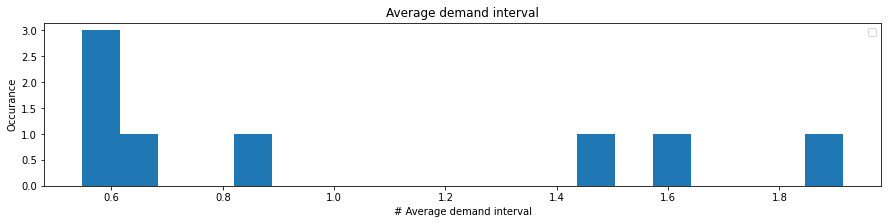

In [37]:
plt.figure(figsize=(15,3))
plt.hist(cv_data['cv_sqr'], bins = 20)
plt.legend()
plt.title("Average demand interval")
plt.ylabel("Occurance")
plt.xlabel("# Average demand interval")
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


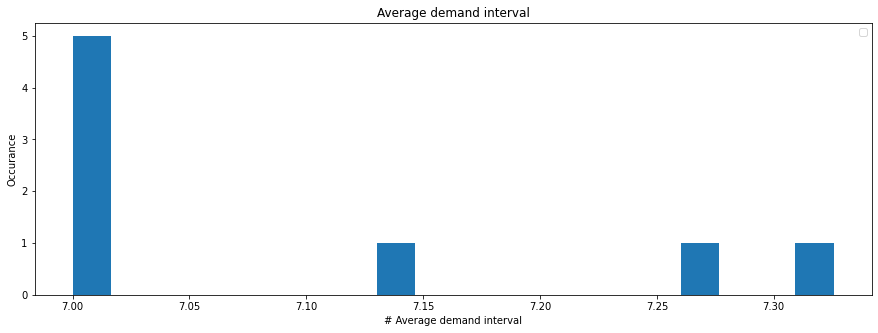

In [38]:
plt.figure(figsize=(15,5))
plt.hist(ADI['ADI'], bins = 20)
plt.legend()
plt.title("Average demand interval")
plt.ylabel("Occurance")
plt.xlabel("# Average demand interval")
plt.show()

<AxesSubplot:xlabel='cv_sqr', ylabel='ADI'>

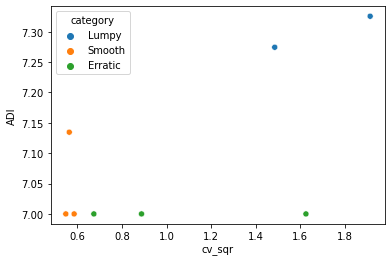

In [39]:
def category(df):
    a=0
    
    if((df['ADI']<=7.2) & (df['cv_sqr']<=0.6)):
        a='Smooth'
    if((df['ADI']>=7.2) & (df['cv_sqr']>=0.6)):  
        a='Lumpy'
    if((df['ADI']<7.2) & (df['cv_sqr']>0.6)):
        a='Erratic'
    if((df['ADI']>7.2) & (df['cv_sqr']<0.6)):
        a='Intermittent'
    return a


## Categorizing products based on their forcastability

adi_cv['category']=adi_cv.apply(category,axis=1)
adi_cv.loc[adi_cv['category'] == 0,'category'] = 'Erratic'
adi_cv.category.value_counts()
import seaborn as sns
## Visualizing the categories
adi_cv_daily = adi_cv
sns.scatterplot(x='cv_sqr',y='ADI',hue='category',data=adi_cv_daily)

In [40]:
att_taiwan = pd.read_excel('../../data/raw/Attribute_and_data_points.xlsx', sheet_name='Attributes_Taiwan')
att_taiwan.rename(columns={'sku type':'sku_type','Level2':'level2','SKU Description':'description'},inplace=True)
att_taiwan.drop(columns={'description'},inplace=True)
att_taiwan['sku'] = att_taiwan['sku'].astype(str)
att_taiwan_all = pd.merge(att_df,att_taiwan,on='sku')
att_taiwan_all


,sku_desc,sku,prod_hierarchy,prod_code,description,sku_type,size,units,cases,level2,shortname
0,FAB (ULTRA CRM 56.7GX3)X1 TW [CS] [80692947] (...,80692947,FAB,10024911.0,FAB ULTRAR CRM 56.7G(2.0OZ)X6X13 TW,Cream,2.0,Oz,78,Ultra Repair,URC*3
1,FAB ULTRAR CRM 56.7G(2.0OZ)X6X15 TW [IT] [8233...,82332932,FAB,9864145.0,FAB ULTRAR CRM 56.7G(2.0OZ)X6X13 TW,Cream,2.0,Oz,78,Ultra Repair,URC
2,FAB ULTRA HYDRATE SERUM 50MLX3X23 TW [IT] [823...,82332207,FAB,10024914.0,FAB ULTRAT SERUM P 50ML(1.7OZ)X3X23,Serum,1.7,Oz,69,Ultra Repair,Serum
3,FAB ULTRA OAT SOOTHING TNR 177MLX6X8 TW [IT] [...,82332219,FAB,10024913.0,FAB ULTRAR TONER P 177ML(60Z)X6X8 NONSTK,Toner,6.0,Oz,48,Ultra Repair,Toner
4,FAB PURE SKIN FACE CLEANSER 142GX57 TW [IT] [8...,80702886,FAB,10024916.0,FAB CLEANSER EUP 142G(50Z)X57 NONSTK,Cleanser,5.0,Oz,57,NaN,Cleanser
5,FAB ULTRA REPAIR OAT MASK 56.7GX42 [IT] [82332...,82332208,FAB,9222618.0,FAB ULTRAR MASK 56.7G(2.0OZ)X42 NONSTK,Cream,2.0,Oz,42,Ultra Repair,Oatmeal Mask
6,FAB ULTRAR OILC MOIST 50ML 1.7OZX6X8 TW [IT] [...,80710476,FAB,9222614.0,FAB ULT OILC MOIST 50ML(1.7OZ)X6X8,Moistrizer,1.7,Oz,48,Ultra,OCC
7,FAB FACIAL RAD PAD 60CTX3X12 TW [IT] [82332800...,82332800,FAB,10080881.0,FAB ULTRAR TONER P 177ML(6OZ)X6X8 NONSTK,Toner,6.0,Oz,48,Ultra Repair,Radiance Pad


In [41]:
offtake_final['sku'] = offtake_final['sku'].astype('int64')
shipment_df_final['sku'] = shipment_df_final['sku'].astype('int64')
inv_df_final['sku'] = inv_df_final['sku'].astype('int64')
att_taiwan_all['sku_name'] = att_taiwan_all['sku'].astype(str) + str("_") + att_taiwan_all['shortname'].astype(str) 

att_taiwan_all['sku'] = att_taiwan_all['sku'].astype('int64')

In [43]:
offtake_final.to_csv("../../data/ui/offtake_taiwan.csv",index=False)
att_taiwan_all.to_csv("../../data/ui/attribute_taiwan.csv",index=False)
shipment_df_final.to_csv("../../data/ui/shipment_taiwan.csv",index=False)
inv_df_final.to_csv("../../data/ui/inventory_taiwan.csv",index=False)


In [34]:
offtake_final.head()

,date,offtake,sku,list_price,suggested_regular_price
0,2021-08-23,1.0,80702886,633.3,950
1,2021-08-30,5.0,80702886,633.3,950
2,2021-09-06,13.0,80702886,633.3,950
3,2021-09-13,12.0,80702886,633.3,950
4,2021-09-20,34.0,80702886,633.3,950


In [35]:
freq = "W-Mon"
shipment_weekly = shipment_df_final.set_index("date").groupby('sku').resample(freq,label='left',closed = 'left').sum().drop(columns={'sku'}).reset_index()
shipment_weekly.head()

,sku,date,shipment_volume,shipment_value
0,80692947,2021-10-18,4000,3680000.0
1,80692947,2021-10-25,0,0.0
2,80692947,2021-11-01,0,0.0
3,80692947,2021-11-08,0,0.0
4,80692947,2021-11-15,0,0.0


In [36]:
shipment_weekly.to_csv("shipment_weekly.csv")

In [37]:
combine_df = pd.merge(offtake_final,shipment_weekly,on=['sku','date'],how='outer')
combine_df.fillna(0,inplace=True)
combine_df.sort_values(by=['sku','date'],inplace=True)
combine_df['offtake_sum'] = combine_df.groupby(['sku'])['offtake'].cumsum()
combine_df['shipment_volume_sum'] = combine_df.groupby(['sku'])['shipment_volume'].cumsum()
combine_df.head()

,date,offtake,sku,list_price,suggested_regular_price,shipment_volume,shipment_value,offtake_sum,shipment_volume_sum
324,2021-10-18,100.0,80692947,920.0,1380.0,4000.0,3680000.0,100.0,4000.0
325,2021-10-25,519.0,80692947,920.0,1380.0,0.0,0.0,619.0,4000.0
326,2021-11-01,787.0,80692947,920.0,1380.0,0.0,0.0,1406.0,4000.0
327,2021-11-08,1108.0,80692947,920.0,1380.0,0.0,0.0,2514.0,4000.0
328,2021-11-15,93.0,80692947,920.0,1380.0,0.0,0.0,2607.0,4000.0


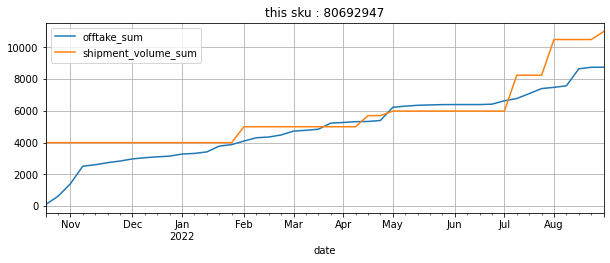

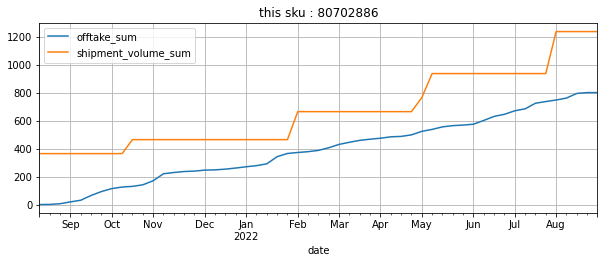

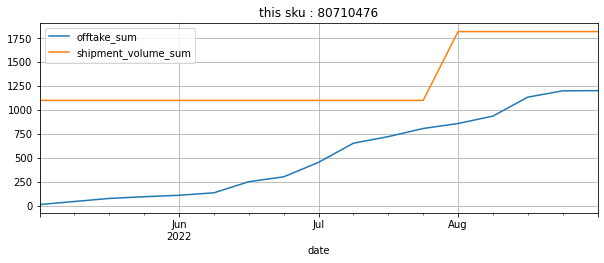

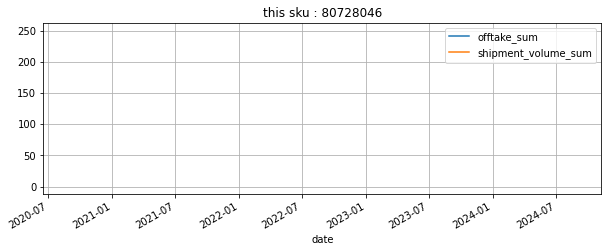

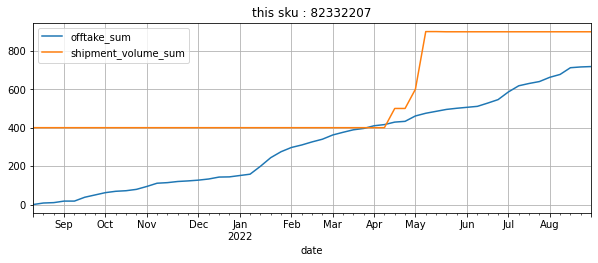

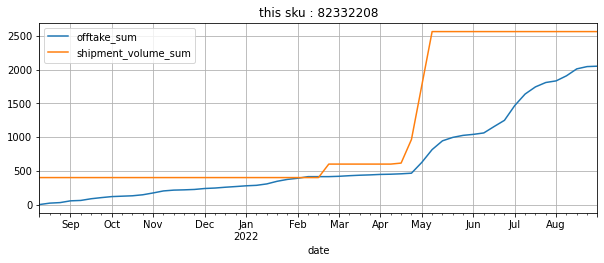

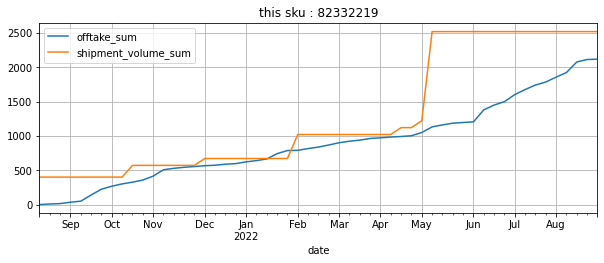

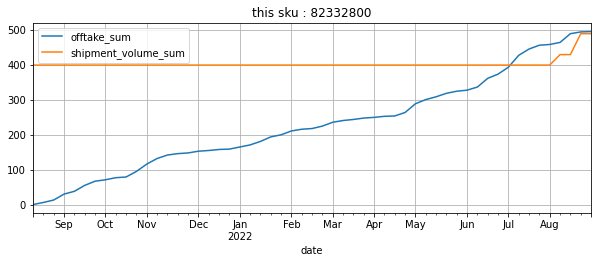

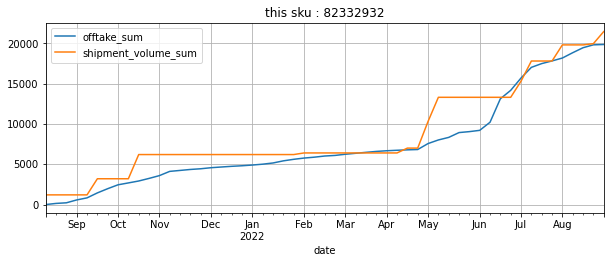

In [38]:
all_skus = combine_df.sku.unique()
for this_sku in all_skus:
    this_df = combine_df[combine_df['sku'] == this_sku]
    this_df.plot(x="date", y=["offtake_sum", "shipment_volume_sum"], figsize=(10, 3.5), grid=True)
    plt.title("this sku : " + str(this_sku))
    plt.show()

In [39]:
abc_xyz['sku'] = abc_xyz['sku'].astype('int64')
abc_xyz1 = pd.merge(abc_xyz,att_taiwan_all,on='sku')
adi_cv['sku'] = adi_cv['sku'].astype('int64')
adi_cv1 = pd.merge(adi_cv,att_taiwan_all,on='sku')
offtake_final['sku'] = offtake_final['sku'].astype('int64')
offtake_final1 = pd.merge(offtake_final,att_taiwan_all,on='sku')
shipment_df_final['sku'] = shipment_df_final['sku'].astype('int64')
shipment_df_final1 = pd.merge(shipment_df_final,att_taiwan_all,on='sku')
inv_df_final1 = pd.merge(inv_df_final,att_taiwan_all,on='sku')

In [40]:
write_data_table.send_data(abc_xyz1,"abc_xyz_taiwan","w6")
write_data_table.send_data(adi_cv1,"quadrant_taiwan","w6")
write_data_table.send_data(offtake_final1,"offtake_taiwan","w6")
write_data_table.send_data(shipment_df_final1,"shipment_taiwan","w6")
write_data_table.send_data(inv_df_final1,"inventory_taiwan","w6")
write_data_table.send_data(att_taiwan_all,"attributes_taiwan","w6")



Index(['sku', 'revenue', 'rev_cumsum', 'ABC', 'std', 'mean', 'CV', 'XYZ',
       'ABC_XYZ', 'sku_desc', 'prod_hierarchy', 'prod_code', 'description',
       'sku_type', 'size', 'units', 'cases', 'level2', 'shortname',
       'sku_name'],
      dtype='object')
Index(['sku', 'ADI', 'average', 'sd', 'cv_sqr', 'category', 'sku_desc',
       'prod_hierarchy', 'prod_code', 'description', 'sku_type', 'size',
       'units', 'cases', 'level2', 'shortname', 'sku_name'],
      dtype='object')
Index(['date', 'offtake', 'sku', 'list_price', 'suggested_regular_price',
       'sku_desc', 'prod_hierarchy', 'prod_code', 'description', 'sku_type',
       'size', 'units', 'cases', 'level2', 'shortname', 'sku_name'],
      dtype='object')
Index(['date', 'sku', 'shipment_volume', 'shipment_value', 'sku_desc',
       'prod_hierarchy', 'prod_code', 'description', 'sku_type', 'size',
       'units', 'cases', 'level2', 'shortname', 'sku_name'],
      dtype='object')
Index(['sku', 'date', 'inventory', 'sku_des

In [41]:

def get_events():
    """
    Hard coded events for now.
    Following Prophet's format
    """
    cny_promotion = pd.DataFrame({
        'holiday': 'cny',
        'ds': pd.to_datetime(['2019-02-5', '2020-01-25', '2021-02-12', '2022-02-01', '2023-01-22']),
        'lower_window': -7,
        'upper_window': 7,
        'type': 'festival',
    })

    # 3 weeks before actual date
    pre_cny_promotion = pd.DataFrame({
        'holiday': 'pre_cny',
        'ds': pd.to_datetime(['2019-01-14', '2019-12-30', '2021-01-18', '2022-01-10', '2023-01-01']),
        'lower_window': 0,
        'upper_window': 21,
        'type': 'promotion',
    })

    women_day_promotion = pd.DataFrame({
        'holiday': 'women day',
        'ds': pd.to_datetime(['2019-03-08', '2020-03-08', '2021-03-08', '2022-03-08', '2023-03-08']),
        'lower_window': 0,
        'upper_window': 0,
        'type': 'promotion_specific_date',
    })

    mother_day_promotion = pd.DataFrame({
        'holiday': 'mothers day',
        'ds': pd.to_datetime(['2019-05-12', '2020-05-10', '2021-05-09', '2022-05-08', '2023-05-14']),
        'lower_window': -7,
        'upper_window': 0,
        'type': 'promotion_specific_date',
    })

    day_520_promotion = pd.DataFrame({
        'holiday': '520',
        'ds': pd.to_datetime(['2019-05-20', '2020-05-20', '2021-05-20', '2022-05-20', '2023-05-20']),
        'lower_window': 0,
        'upper_window': 0,
        'type': 'promotion_specific_date',
    })

    day_618_promotion = pd.DataFrame({
        'holiday': '618',
        'ds': pd.to_datetime(['2019-06-18', '2020-06-18', '2021-06-18', '2022-06-18', '2023-06-18']),
        'lower_window': -14,
        'upper_window': 14,
        'type': 'promotion_specific_date',
    })

    day_99_promotion = pd.DataFrame({
        'holiday': '9.9',
        'ds': pd.to_datetime(['2019-09-09', '2020-09-09', '2021-09-09', '2022-09-09', '2023-09-09']),
        'lower_window': -7,
        'upper_window': 7,
        'type': 'promotion_specific_date',
    })

    day_1111_promotion = pd.DataFrame({
        'holiday': '11.11',
        'ds': pd.to_datetime(['2019-11-11', '2020-11-11', '2021-11-11', '2022-11-11', '2023-11-11']),
        'lower_window': -14,
        'upper_window': 7,
        'type': 'promotion_specific_date',
    })

    day_1212_promotion = pd.DataFrame({
        'holiday': '12.12',
        'ds': pd.to_datetime(['2019-12-12', '2020-12-12', '2021-12-12', '2022-12-12', '2023-12-12']),
        'lower_window': -7,
        'upper_window': 7,
        'type': 'promotion_specific_date',
    })

    black_friday_promotion = pd.DataFrame({
        'holiday': 'black_friday',
        'ds': pd.to_datetime(['2019-11-29', '2020-11-27', '2021-11-26', '2022-11-25', '2023-11-24']),
        'lower_window': -7,
        'upper_window': 7,
        'type': 'promotion_specific_date',
    })

    christmas_promotion = pd.DataFrame({
        'holiday': 'christmas',
        'ds': pd.to_datetime(['2019-12-25', '2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25']),
        'lower_window': -7,
        'upper_window': 7,
        'type': 'festival',
    })

    events = pd.concat((
        pre_cny_promotion,
        cny_promotion,
        women_day_promotion,
        mother_day_promotion,
        day_520_promotion,
        day_618_promotion,
        day_99_promotion,
        day_1111_promotion,
        day_1212_promotion,
        black_friday_promotion,
        christmas_promotion,
    )).reset_index(drop=True)

    a = pd.get_dummies(events["type"])
    events = pd.concat([events, a], axis=1)
    return events

events = get_events()
events['upper_window']  = events['upper_window'].astype(int)
events['lower_window']  = events['lower_window'].astype(int)
events['festival']  = events['festival'].astype(int)
events['promotion']  = events['promotion'].astype(int)
events['promotion_specific_date']  = events['promotion_specific_date'].astype(int)
events_weekly = []
for h in events.holiday.unique():
    # for each event, resample it to W-Mon
    e = events.loc[events.holiday == h]
    e = e.set_index("ds").resample("W-Mon", label="left").first()
    e.dropna(inplace=True)
    events_weekly.append(e.reset_index())
event_types = pd.get_dummies(events["type"]).columns.to_list()
events_weekly = pd.concat(events_weekly)
tmp = []
for t in events_weekly.ds.unique():
    e = events_weekly.loc[events_weekly.ds == t].reset_index(drop=True)
    if len(e) == 1:
        tmp.append(e.drop(columns=["lower_window", "upper_window"]))
    else:
        e.drop(columns=["lower_window", "upper_window"], inplace=True)
        e["holiday"] = ",".join(e["holiday"].tolist())
        e["type"] = ",".join(e["type"].tolist())
        _sum = e[event_types].sum()
        for c in event_types:
            e[c] = _sum[c]
        tmp.append(e.drop_duplicates())
events_weekly = pd.concat(tmp)
events_weekly.sort_values(by="ds", inplace=True)
events_weekly.reset_index(inplace=True, drop=True)

In [33]:
write_data_table.send_data(events_weekly,"events","w6")

Index(['ds', 'holiday', 'type', 'festival', 'promotion',
       'promotion_specific_date'],
      dtype='object')


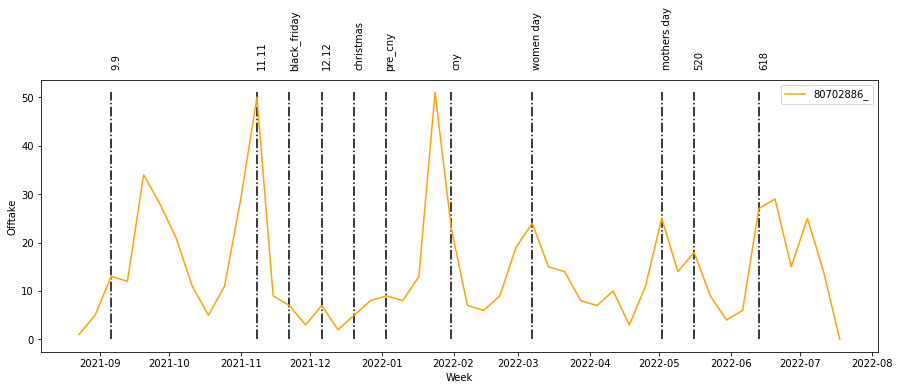

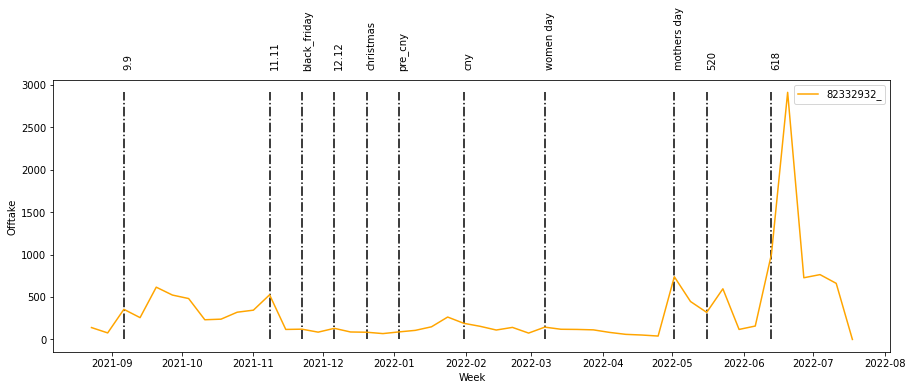

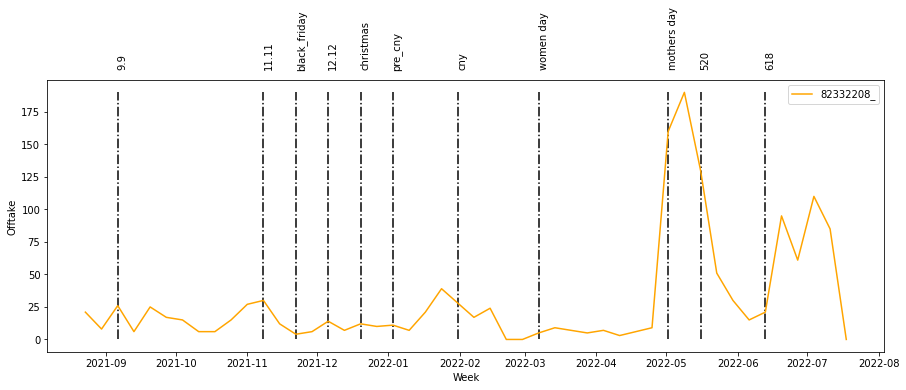

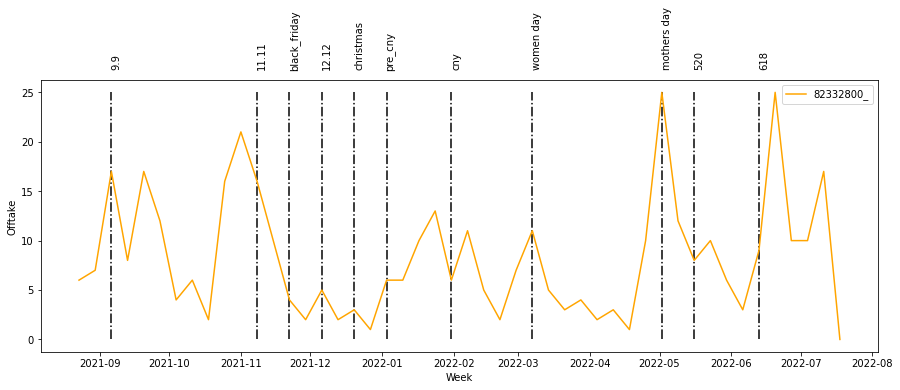

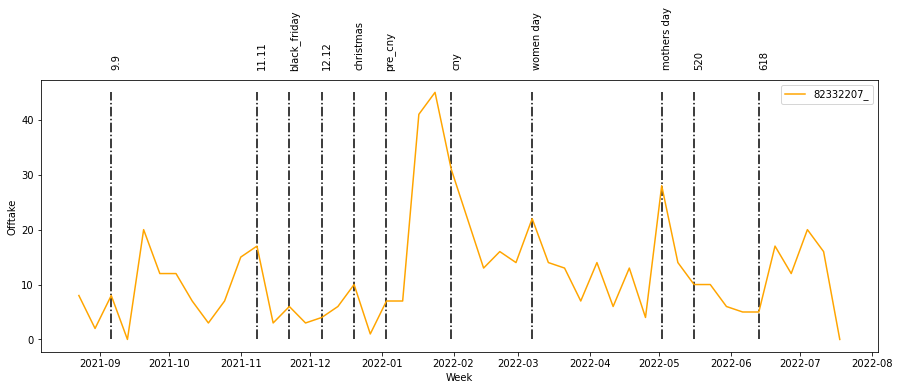

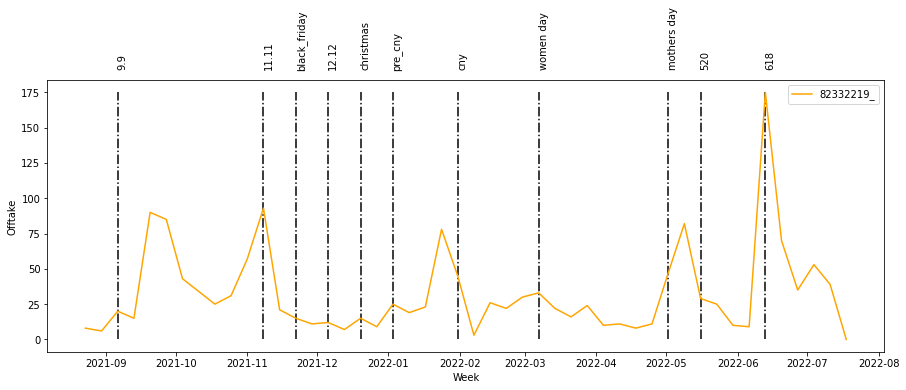

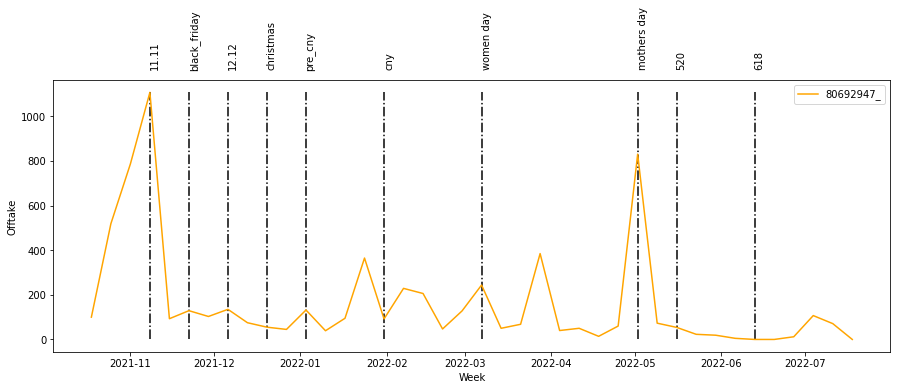

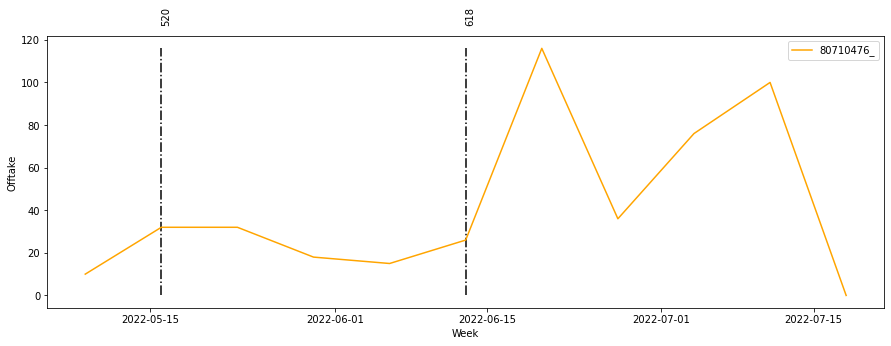

In [34]:
skus = data.sku.unique()
for this_sku in skus:
    this_data = data[data['sku'] == this_sku].groupby("date")['offtake'].sum().reset_index()
    plt.figure(figsize=(15,5))
       #plt.plot(this_stt.ts, this_stt.y, label="stt"+ "_"+brand, c="darkblue")
    max_val = this_data.offtake.max()
    this_event_weekly  = events_weekly[ (events_weekly['ds'] <= this_data.date.max()) & (events_weekly['ds'] >= this_data.date.min())].reset_index()
   # print(this_event_weekly)
    for i in range(len(this_event_weekly)):
        plt.plot([this_event_weekly.ds[i], this_event_weekly.ds[i]], [0, max_val], "k-.")
        if (this_event_weekly.ds[i] > this_data.date.min()) and (this_event_weekly.ds[i] < this_data.date.max()):
            plt.text(this_event_weekly.ds[i], max_val*1.1, this_event_weekly.holiday[i], rotation=90)
    plt.plot(this_data.date, this_data.offtake, label= str(this_sku) + "_", c="orange")
    plt.legend(loc = "upper right")
   
   # plt.title("Shipment per Brand")
    plt.ylabel("Offtake")
    plt.xlabel("Week")
    plt.show()

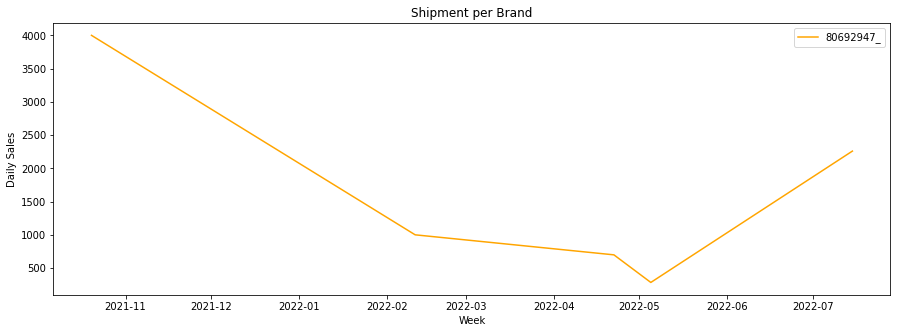

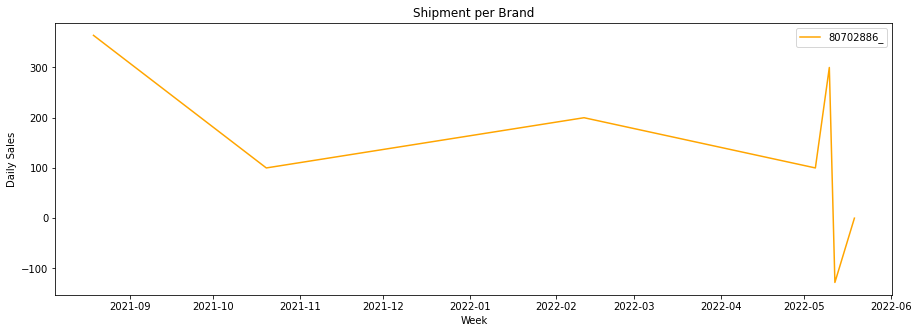

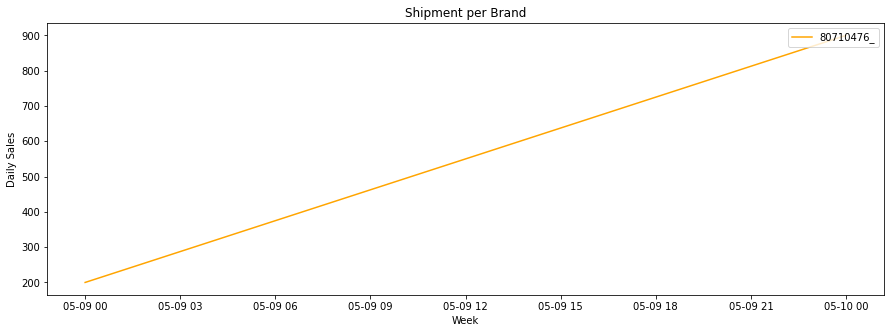

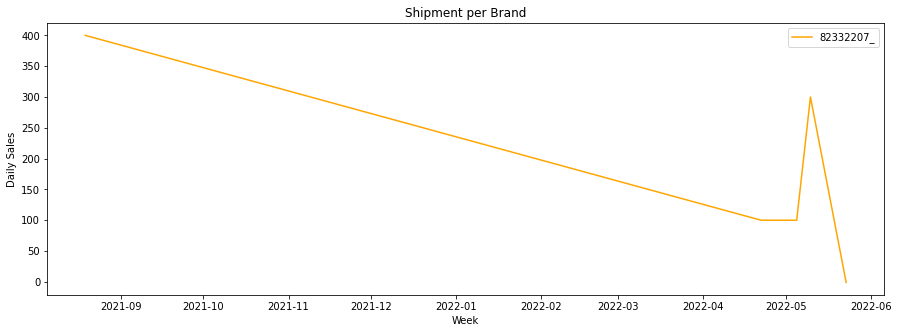

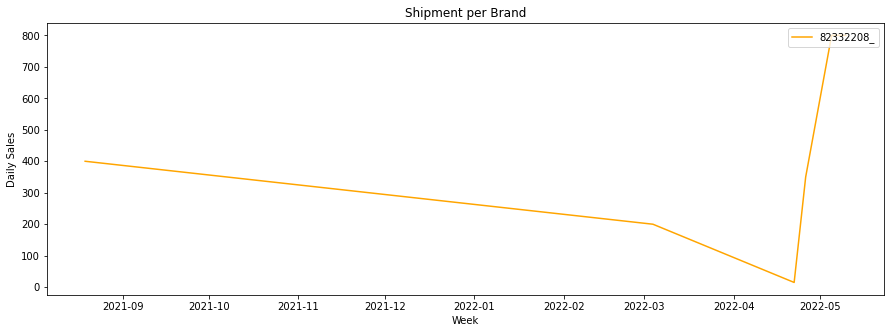

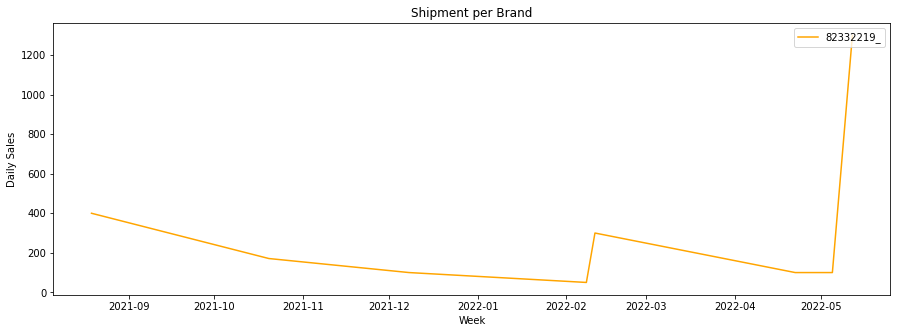

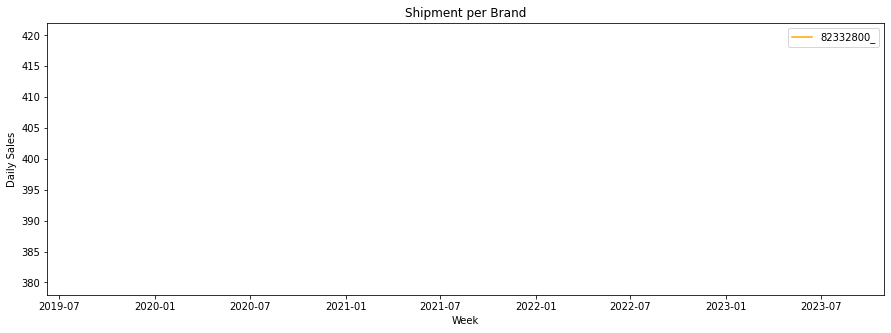

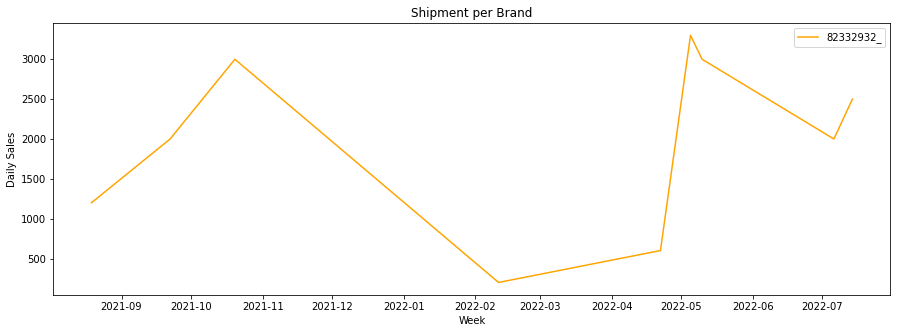

In [35]:
skus = shipment_df.sku.unique()
for this_sku in skus:
    this_data = shipment_df[shipment_df['sku'] == this_sku].groupby("date")['shipment_volume'].sum().reset_index()
    plt.figure(figsize=(15,5))
       #plt.plot(this_stt.ts, this_stt.y, label="stt"+ "_"+brand, c="darkblue")
    plt.plot(this_data.date, this_data.shipment_volume, label= str(this_sku) + "_", c="orange")
    plt.legend(loc = "upper right")
   
    plt.title("Shipment per Brand")
    plt.ylabel("Daily Sales")
    plt.xlabel("Week")
    plt.show()